Epoch 1/50


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1342 - val_loss: 0.0862
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0841 - val_loss: 0.0850
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0883 - val_loss: 0.0871
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0856 - val_loss: 0.0849
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0852 - val_loss: 0.0846
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0844 - val_loss: 0.0851
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0825 - val_loss: 0.0840
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0834 - val_loss: 0.0846
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0843 - val_loss: 0.0862
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0845 - val_loss: 0.0844
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0830 - val_loss: 0.0836
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0851 - val_l

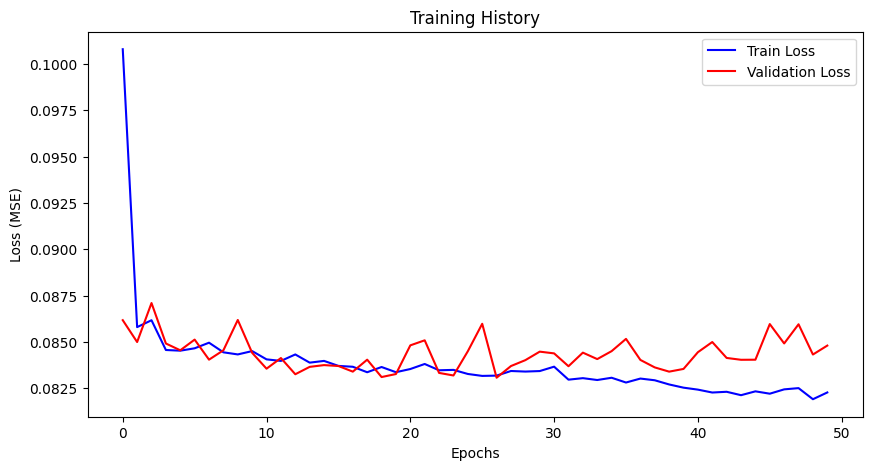

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


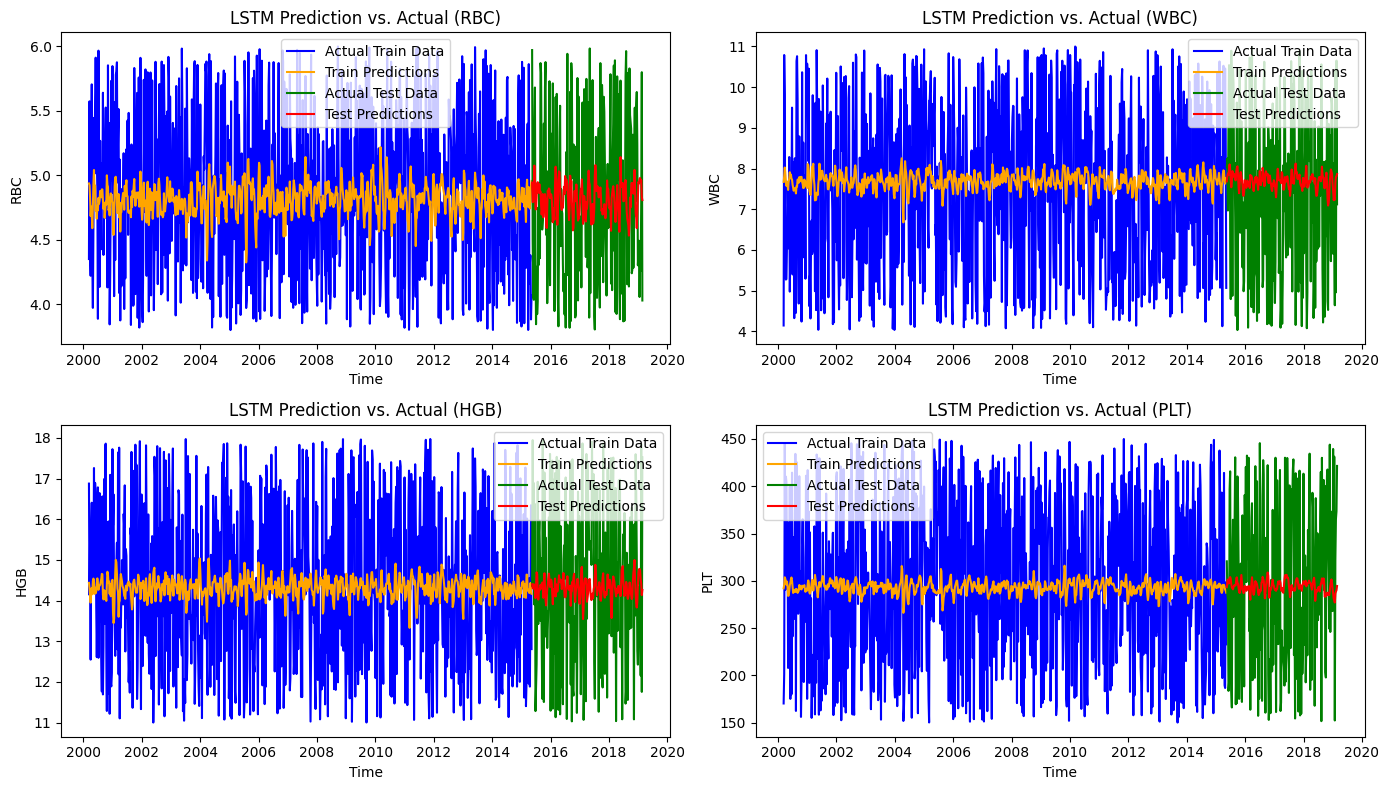

RBC - Train RMSE: 0.61, Train MAE: 0.52
RBC - Test RMSE: 0.64, Test MAE: 0.56
WBC - Train RMSE: 2.04, Train MAE: 1.77
WBC - Test RMSE: 2.04, Test MAE: 1.76
HGB - Train RMSE: 1.94, Train MAE: 1.66
HGB - Test RMSE: 2.00, Test MAE: 1.71
PLT - Train RMSE: 86.71, Train MAE: 75.30
PLT - Test RMSE: 87.58, Test MAE: 76.53
You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model

# Load dataset
df = pd.read_csv("synthetic_cbc_weekly_data.csv", parse_dates=["Timestamp"], index_col="Timestamp")

# Select multiple features for prediction
target_columns = ["RBC", "WBC", "HGB", "PLT"]
data = df[target_columns]

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Convert to DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=target_columns, index=df.index)

# Prepare dataset for LSTM
look_back = 10  # Number of past observations to use for prediction

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled.values, look_back)

# Split into training and test sets
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, len(target_columns))),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(len(target_columns))
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training History")
plt.legend()
plt.show()

# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Inverse transform predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

# Visualizing Predictions
plt.figure(figsize=(14, 8))

for i, col in enumerate(target_columns):
    plt.subplot(2, 2, i+1)
    plt.plot(df.index[look_back:split+look_back], y_train_actual[:, i], label="Actual Train Data", color="blue")
    plt.plot(df.index[look_back:split+look_back], trainPredict[:, i], label="Train Predictions", color="orange")

    plt.plot(df.index[split+look_back:], y_test_actual[:, i], label="Actual Test Data", color="green")
    plt.plot(df.index[split+look_back:], testPredict[:, i], label="Test Predictions", color="red")

    plt.xlabel("Time")
    plt.ylabel(col)
    plt.title(f"LSTM Prediction vs. Actual ({col})")
    plt.legend()

plt.tight_layout()
plt.show()

# Evaluation Metrics
for i, col in enumerate(target_columns):
    train_rmse = np.sqrt(mean_squared_error(y_train_actual[:, i], trainPredict[:, i]))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], testPredict[:, i]))
    train_mae = mean_absolute_error(y_train_actual[:, i], trainPredict[:, i])
    test_mae = mean_absolute_error(y_test_actual[:, i], testPredict[:, i])
    
    print(f"{col} - Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}")
    print(f"{col} - Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f}")

# Model Architecture Visualization
plot_model(model, show_shapes=True, show_layer_names=True, to_file="model_structure.png")


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.1444 - val_loss: 0.0795
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0833 - val_loss: 0.0758
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0791 - val_loss: 0.0784
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0786 - val_loss: 0.0760
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0767 - val_loss: 0.0766
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0773 - val_loss: 0.0773
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0797 - val_loss: 0.0755
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0777 - val_loss: 0.0770
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0766 - val_loss: 0.0767
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0795 - val_loss: 0.0763
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0766 - val_loss: 0.0771
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

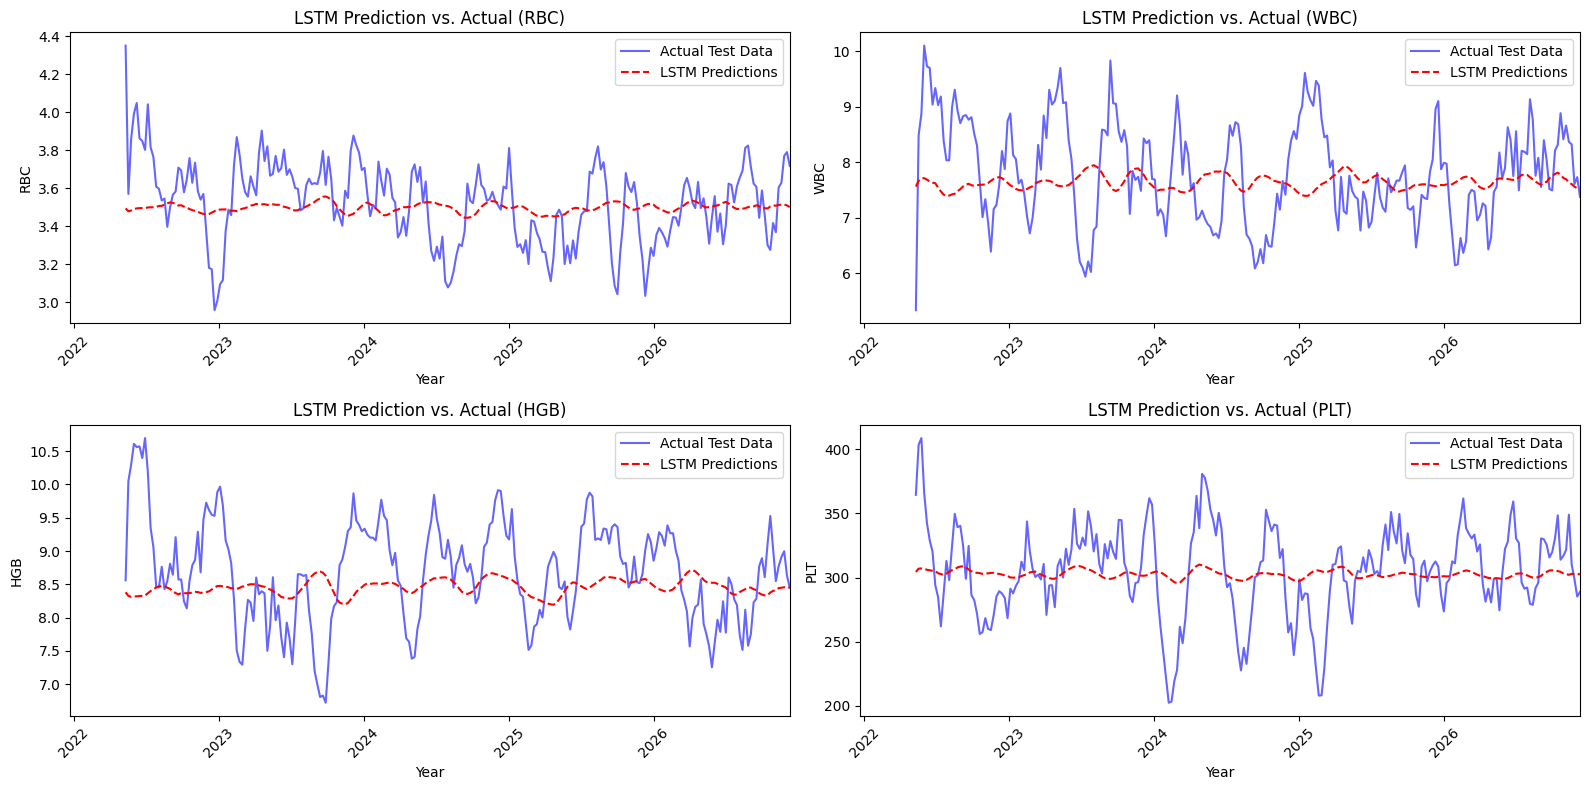

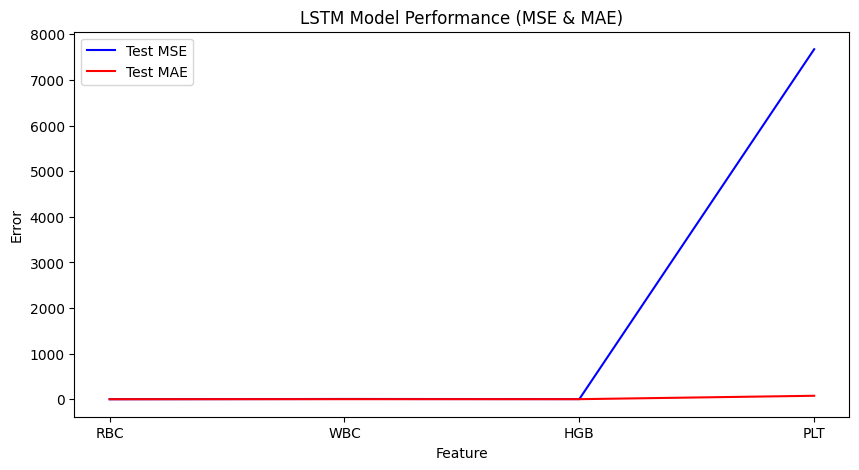

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="keras")

# 🔹 Load Dataset
df = pd.read_excel("synthetic_sickle_cbc_updated2.xlsx", parse_dates=["Timestamp"], index_col="Timestamp")

# 🔹 Select multiple features for prediction
target_columns = ["RBC", "WBC", "HGB", "PLT"]
data = df[target_columns]

# 🔹 Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=target_columns, index=df.index)

# 🔹 Split into training & testing sets (80% train, 20% test)
split = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:split], data_scaled[split:]

# 🔹 Create sequences for LSTM
def create_sequences(dataset, look_back=10):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_sequences(data_scaled.values, look_back)

# 🔹 Split sequences into training and testing sets
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# 🔹 Define LSTM Model
model = Sequential([
    Input(shape=(look_back, len(target_columns))),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(len(target_columns))
])

model.compile(optimizer="adam", loss="mse")

# 🔹 Train LSTM Model
history = model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_test, Y_test), verbose=1)

# 🔹 LSTM Predictions
lstm_train_predicted = model.predict(X_train)
lstm_test_predicted = model.predict(X_test)

# 🔹 Inverse Transform Predictions & Actual Values
lstm_train_predicted = scaler.inverse_transform(lstm_train_predicted)
lstm_test_predicted = scaler.inverse_transform(lstm_test_predicted)
Y_train_actual = scaler.inverse_transform(Y_train)
Y_test_actual = scaler.inverse_transform(Y_test)

# 🔹 Evaluation Metrics (MSE & MAE)
mse_values = {}
mae_values = {}

for i, col in enumerate(target_columns):
    mse_values[col] = mean_squared_error(Y_test_actual[:, i], lstm_test_predicted[:, i])
    mae_values[col] = mean_absolute_error(Y_test_actual[:, i], lstm_test_predicted[:, i])
    print(f"{col} - Test MSE: {mse_values[col]:.4f}, Test MAE: {mae_values[col]:.4f}")

# 🔹 Moving Average for Better Visualization (7-week smoothing)
window_size = 7
test_actual_smooth = pd.DataFrame(Y_test_actual, columns=target_columns).rolling(window=window_size, min_periods=1).mean().values
test_predicted_smooth = pd.DataFrame(lstm_test_predicted, columns=target_columns).rolling(window=window_size, min_periods=1).mean().values

# 🔹 Visualization: Actual vs. Predicted (Last 5 Years)
recent_years_index = df.index[-(5 * 52):]

plt.figure(figsize=(16, 8))
for i, col in enumerate(target_columns):
    plt.subplot(2, 2, i+1)
    
    # Actual Data
    plt.plot(df.index[split + look_back:], test_actual_smooth[:, i], label="Actual Test Data", color="blue", alpha=0.6)
    # Predicted Data
    plt.plot(df.index[split + look_back:], test_predicted_smooth[:, i], label="LSTM Predictions", color="red", linestyle="dashed")

    plt.xlabel("Year")
    plt.ylabel(col)
    plt.title(f"LSTM Prediction vs. Actual ({col})")
    plt.legend()

    # Set X-axis to yearly ticks
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # 🔹 Focus on Last 5 Years
    plt.xlim([recent_years_index.min(), recent_years_index.max()])

plt.tight_layout()
plt.show()

# 🔹 Loss Visualization: Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(list(mse_values.values()), label="Test MSE", color="blue")
plt.plot(list(mae_values.values()), label="Test MAE", color="red")
plt.xlabel("Feature")
plt.ylabel("Error")
plt.title("LSTM Model Performance (MSE & MAE)")
plt.xticks(range(len(target_columns)), target_columns)
plt.legend()
plt.show()





In [ ]:
import joblib
import tensorflow as tf

# Save LSTM Model
model.save("lstm_model.h5")

In [5]:
import joblib
import tensorflow as tf

# Save LSTM Model
model.save("lstm_model2.h5")

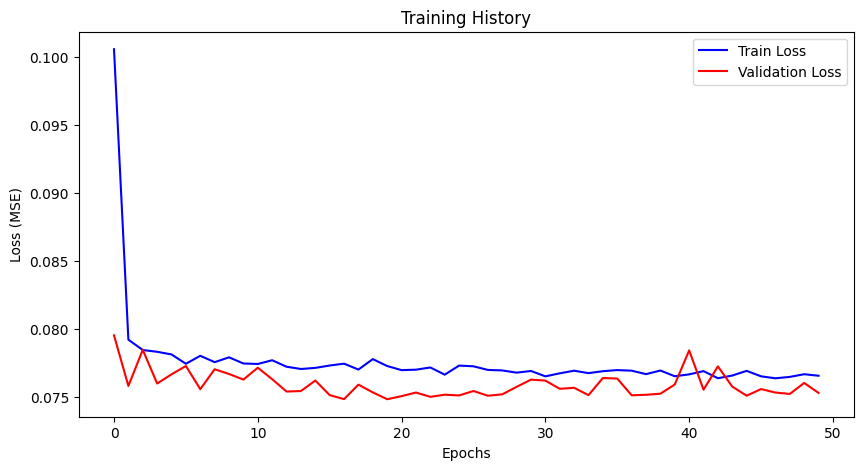

In [6]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training History")
plt.legend()
plt.show()


In [7]:
def forecast_future(model, last_sequence, steps=30):
    """Predicts future CBC values based on the last known data sequence."""
    future_predictions = []

    # Start with the last available data sequence
    current_input = last_sequence.copy()

    for _ in range(steps):
        # Predict the next time step
        prediction = model.predict(current_input.reshape(1, look_back, len(target_columns)), verbose=0)
        
        # Append prediction to future results
        future_predictions.append(prediction[0])

        # Update input sequence (shift left and add new prediction)
        current_input = np.vstack([current_input[1:], prediction])

    return np.array(future_predictions)

# 🔹 Get last known sequence from test data
last_sequence = X_test[-1]

# 🔹 Forecast for the next 30 days (or weeks)
future_steps = 30
future_predictions = forecast_future(model, last_sequence, steps=future_steps)

# 🔹 Inverse transform the predictions back to the original scale
future_predictions = scaler.inverse_transform(future_predictions)

# 🔹 Create future timestamps
future_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='D')[1:]

# 🔹 Convert to DataFrame
future_df = pd.DataFrame(future_predictions, columns=target_columns, index=future_dates)

# 🔹 Display predicted future CBC values
print(future_df.head())


                 RBC       WBC       HGB         PLT
2026-12-10  3.488578  7.549931  8.507513  300.309326
2026-12-11  3.474740  7.674482  8.439785  303.223938
2026-12-12  3.491672  7.645577  8.489486  303.590729
2026-12-13  3.492616  7.731811  8.457087  304.057068
2026-12-14  3.509861  7.684995  8.524467  300.628113


In [9]:
# 🔹 Get predictions on test data
lstm_test_predictions = model.predict(X_test)

# 🔹 Convert predictions back to original scale (if normalized/scaled)
lstm_test_predictions = scaler.inverse_transform(lstm_test_predictions)  # Only if you used scaling


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [10]:
import pandas as pd

# 🔹 Create a DataFrame for better visualization
test_comparison = pd.DataFrame({
    "Actual_RBC": Y_test_actual[:, 0],  # Replace with actual column names
    "Predicted_RBC": lstm_test_predictions[:, 0],
    "Actual_WBC": Y_test_actual[:, 1],
    "Predicted_WBC": lstm_test_predictions[:, 1],
    "Actual_HGB": Y_test_actual[:, 2],
    "Predicted_HGB": lstm_test_predictions[:, 2],
    "Actual_PLT": Y_test_actual[:, 3],
    "Predicted_PLT": lstm_test_predictions[:, 3],
})

# 🔹 Print the first few rows
print(test_comparison.head(10))


   Actual_RBC  Predicted_RBC  Actual_WBC  Predicted_WBC  Actual_HGB  \
0        4.35       3.493815        5.33       7.561084        8.56   
1        2.79       3.464259       11.64       7.766308       11.54   
2        4.44       3.490681        9.66       7.794882       10.80   
3        4.39       3.515118       13.78       7.723677       11.54   
4        4.27       3.505914        8.23       7.581920       10.37   
5        2.93       3.503200        9.55       7.489727       10.62   
6        3.77       3.496754        5.08       7.504721        9.35   
7        4.02       3.491278        7.41       7.479290       10.66   
8        4.47       3.490180        9.49       7.226367        7.99   
9        2.86       3.496669       10.75       7.304667        4.91   

   Predicted_HGB  Actual_PLT  Predicted_PLT  
0       8.380895      364.43     304.376984  
1       8.272159      442.53     309.441406  
2       8.283271      419.09     307.373779  
3       8.339614      237.48     3

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 🔹 Calculate error metrics
for i, col in enumerate(["RBC", "WBC", "HGB", "PLT"]):
    mse = mean_squared_error(Y_test_actual[:, i], lstm_test_predictions[:, i])
    mae = mean_absolute_error(Y_test_actual[:, i], lstm_test_predictions[:, i])
    print(f"{col} - Test MSE: {mse:.4f}, Test MAE: {mae:.4f}")


RBC - Test MSE: 0.3428, Test MAE: 0.5058
WBC - Test MSE: 5.7084, Test MAE: 1.9737
HGB - Test MSE: 3.1589, Test MAE: 1.4876
PLT - Test MSE: 7674.2023, Test MAE: 75.9860
